# Radiomic Prediction of Tumor Grade from the BraTS Glioma Dataset: An Exploratory Analysis of Machine Learning Classifiers and Dimensionality Reduction Techniques

## Kareem Wahid
## Colen Lab, MD Anderson Cancer Center
## Last updated: Feburary 27, 2018

This notebook contains all code corresponding to "Radiomic Prediction of Tumor Grade from the BraTS Glioma Dataset: An Exploratory Analysis of Machine Learning Classifiers and Dimensionality Reduction Techniques", a study conducted during the summer/fall of 2017 for the Colen Lab at MD Anderson Cancer Center. It is dependent on output files generated by Pyradiomics v.1.3.0 that are located in the corresponding github folder located at: https://github.com/kwahid/Radiomic-Prediction-of-Tumor-Grade-from-the-BraTS-Glioma-Dataset. All code should be run in order. Model building takes approximatley 4 1/2 hours on a regular CPU. 

An overview of the study is shown in the figure below.

<img src="workflow_figure.png">

## Dependencies

In [1]:
### Import all dependencies 

# Classifiers
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Pre-processing/Feature selection 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, chi2
from sklearn.decomposition import PCA, FastICA, FactorAnalysis, KernelPCA

# Model building 
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, LeaveOneOut, KFold
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, recall_score
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE # for upsampling

# Stats
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy.stats import binom_test # for calculating p-value

# Misc. 
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns; sns.set(color_codes=True) # Makes graphs pretty
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Import and clean data 

In [2]:
radiomic_raw_necrosis = pd.read_csv('grades_t1ce_label1_final.csv') # T1ce/NCR
radiomic_raw_edema = pd.read_csv('grades_flair_label2_final.csv') # FLAIR/ED
radiomic_raw_enhancing = pd.read_csv('grades_t1ce_label4_final.csv') # T1ce/ET

# Add suffixes to phenotypes 
radiomic_raw_necrosis = radiomic_raw_necrosis.add_suffix('_necrosis') 
radiomic_raw_necrosis=radiomic_raw_necrosis.rename(columns = {'Grade_necrosis':'Grade'}) # Keep only one column for grade
radiomic_raw_edema = radiomic_raw_edema.add_suffix('_edema')
radiomic_raw_enhancing = radiomic_raw_enhancing.add_suffix('_enhancing')

In [3]:
radiomic_raw = pd.concat([radiomic_raw_necrosis, radiomic_raw_edema, radiomic_raw_enhancing], axis=1, join='inner') # Join phenotypes into one DataFrame 
radiomic_raw.tail()

,Brats17ID_necrosis,Grade,Image_necrosis,Mask_necrosis,general_info_BoundingBox_necrosis,general_info_EnabledImageTypes_necrosis,general_info_GeneralSettings_necrosis,general_info_ImageHash_necrosis,general_info_ImageSpacing_necrosis,general_info_MaskHash_necrosis,...,original_glszm_HighGrayLevelZoneEmphasis_enhancing,original_glszm_SmallAreaEmphasis_enhancing,original_glszm_LowGrayLevelZoneEmphasis_enhancing,original_glszm_ZoneEntropy_enhancing,original_glszm_SmallAreaLowGrayLevelEmphasis_enhancing,original_ngtdm_Coarseness_enhancing,original_ngtdm_Complexity_enhancing,original_ngtdm_Strength_enhancing,original_ngtdm_Busyness_enhancing,original_ngtdm_Contrast_enhancing
280,Brats17_TCIA_644_1,Low,Brats17_TCIA_644_1_t1ce.nii,Brats17_TCIA_644_1_seg.nii,"(92, 50, 45, 62, 88, 71)","{'LoG': {'sigma': [1.0, 3.0, 5.0]}, 'Wavelet':...","{'distances': [1], 'voxelArrayShift': 300, 'ad...",507bec47ac46c8d5ffd0bc7e18047d7e8fb2211d,"(1.0, 1.0, 1.0)",1c32fca6c7d9381a4c9eb49863e78f6194f468a8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
281,Brats17_TCIA_645_1,Low,Brats17_TCIA_645_1_t1ce.nii,Brats17_TCIA_645_1_seg.nii,"(66, 110, 36, 54, 75, 53)","{'LoG': {'sigma': [1.0, 3.0, 5.0]}, 'Wavelet':...","{'distances': [1], 'voxelArrayShift': 300, 'ad...",591b153d0ce0735775fc5c0d4b0fa1cd374fc431,"(1.0, 1.0, 1.0)",cf86433a7591fed06726f4ed73ba8f1b09cc9104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
282,Brats17_TCIA_650_1,Low,Brats17_TCIA_650_1_t1ce.nii,Brats17_TCIA_650_1_seg.nii,"(102, 141, 15, 28, 32, 29)","{'LoG': {'sigma': [1.0, 3.0, 5.0]}, 'Wavelet':...","{'distances': [1], 'voxelArrayShift': 300, 'ad...",7269e4fd5a22ff2ec0b7142ecb2a6e8f1b879504,"(1.0, 1.0, 1.0)",43f7f5f64ccb2e93e56fefbec45832ab012a069e,...,110.295082,0.724479,0.053077,4.938453,0.047714,0.052504,3.349001,7.984366,0.098103,0.001595
283,Brats17_TCIA_653_1,Low,Brats17_TCIA_653_1_t1ce.nii,Brats17_TCIA_653_1_seg.nii,"(143, 76, 102, 18, 31, 19)","{'LoG': {'sigma': [1.0, 3.0, 5.0]}, 'Wavelet':...","{'distances': [1], 'voxelArrayShift': 300, 'ad...",146ad42e074bf4219372cb402d16827e30e1d884,"(1.0, 1.0, 1.0)",476dacb3173fb8824a9d6185780545b1f8480af3,...,371.834973,0.657470,0.008686,6.597528,0.006828,0.005868,0.888688,3.079863,0.315386,0.000122
284,Brats17_TCIA_654_1,Low,Brats17_TCIA_654_1_t1ce.nii,Brats17_TCIA_654_1_seg.nii,"(60, 40, 61, 71, 84, 68)","{'LoG': {'sigma': [1.0, 3.0, 5.0]}, 'Wavelet':...","{'distances': [1], 'voxelArrayShift': 300, 'ad...",e802c9798d8c27b7caa41d77e4953f388830e0c7,"(1.0, 1.0, 1.0)",ae7596bb8f19d3f71686ad639cece3c45fa7c75a,...,1309.751530,0.693404,0.001571,7.315014,0.001122,0.000730,0.668813,2.361685,0.404956,0.000008


In [4]:
radiomic_raw.shape # show number of rows and columns

(285, 3579)

In [5]:
# Delete all unnecessary columns and rows
radiomic_filtered = radiomic_raw[np.isfinite(radiomic_raw['original_glszm_SmallAreaLowGrayLevelEmphasis_necrosis'])] # drop rows wiw NaN values
radiomic_filtered = radiomic_filtered[np.isfinite(radiomic_filtered['original_glszm_SmallAreaLowGrayLevelEmphasis_edema'])]
radiomic_filtered = radiomic_filtered[np.isfinite(radiomic_filtered['original_glszm_SmallAreaLowGrayLevelEmphasis_enhancing'])]

radiomic_filtered.drop(
    [
        col for col in radiomic_filtered.columns if # drop columns with unnesccsary info 
        'Brats17ID' in col or 
        'Image' in col or
        'Mask' in col or
        'general_info' in col or 
        'Grade_edema' in col or
        'Grade_enhancing' in col
    ],
    axis=1,inplace=True
)

radiomic_filtered.head()

,Grade,original_shape_Maximum3DDiameter_necrosis,original_shape_Compactness2_necrosis,original_shape_Maximum2DDiameterSlice_necrosis,original_shape_Sphericity_necrosis,original_shape_MinorAxis_necrosis,original_shape_Compactness1_necrosis,original_shape_Elongation_necrosis,original_shape_SurfaceVolumeRatio_necrosis,original_shape_Volume_necrosis,...,original_glszm_HighGrayLevelZoneEmphasis_enhancing,original_glszm_SmallAreaEmphasis_enhancing,original_glszm_LowGrayLevelZoneEmphasis_enhancing,original_glszm_ZoneEntropy_enhancing,original_glszm_SmallAreaLowGrayLevelEmphasis_enhancing,original_ngtdm_Coarseness_enhancing,original_ngtdm_Complexity_enhancing,original_ngtdm_Strength_enhancing,original_ngtdm_Busyness_enhancing,original_ngtdm_Contrast_enhancing
0,High,79.824808,0.015897,61.660360,0.251444,28.727591,0.006689,0.332380,1.163740,4514.0,...,3256.932450,0.804171,0.000591,7.253769,0.000505,0.000393,2.431146,2.479674,0.321996,0.000013
1,High,49.588305,0.035588,42.544095,0.328927,31.997822,0.010008,0.901050,0.672909,10430.0,...,5405.430054,0.822382,0.000350,7.392517,0.000300,0.000354,3.573583,3.097173,0.295163,0.000022
2,High,130.522029,0.006851,54.332311,0.189929,38.265005,0.004391,0.222498,1.001932,16412.0,...,4072.890918,0.780720,0.000520,7.271715,0.000433,0.000365,4.847356,10.151235,0.233654,0.000013
3,High,50.119856,0.007892,26.907248,0.199100,23.606679,0.004713,0.424949,2.348707,1106.0,...,1378.111069,0.766678,0.002044,7.057999,0.001756,0.001245,1.494899,2.302587,0.328217,0.000045
4,High,61.432890,0.012292,47.927028,0.230787,37.120214,0.005882,0.890988,0.769011,20231.0,...,3563.964340,0.840988,0.000703,7.393666,0.000627,0.000322,3.736048,3.123272,0.357754,0.000016


In [6]:
radiomic_filtered.shape # number of rows/columns after cleaning

(235, 3541)

In [7]:
# Set positive and negative classes so you can use in classifiers 
radiomic_filtered.loc[radiomic_filtered.Grade == 'Low', 'Grade'] = 0
radiomic_filtered.loc[radiomic_filtered.Grade == 'High', 'Grade'] = 1
radiomic_filtered[['Grade']] = radiomic_filtered[['Grade']].apply(pd.to_numeric)
radiomic_filtered.tail()

,Grade,original_shape_Maximum3DDiameter_necrosis,original_shape_Compactness2_necrosis,original_shape_Maximum2DDiameterSlice_necrosis,original_shape_Sphericity_necrosis,original_shape_MinorAxis_necrosis,original_shape_Compactness1_necrosis,original_shape_Elongation_necrosis,original_shape_SurfaceVolumeRatio_necrosis,original_shape_Volume_necrosis,...,original_glszm_HighGrayLevelZoneEmphasis_enhancing,original_glszm_SmallAreaEmphasis_enhancing,original_glszm_LowGrayLevelZoneEmphasis_enhancing,original_glszm_ZoneEntropy_enhancing,original_glszm_SmallAreaLowGrayLevelEmphasis_enhancing,original_ngtdm_Coarseness_enhancing,original_ngtdm_Complexity_enhancing,original_ngtdm_Strength_enhancing,original_ngtdm_Busyness_enhancing,original_ngtdm_Contrast_enhancing
278,0,39.749214,0.098839,39.293765,0.462355,26.095632,0.016679,0.853657,0.545738,7040.0,...,832.771513,0.749469,0.007213,6.473945,0.006554,0.013757,10.582531,13.683767,0.060623,0.001270
279,0,93.171884,0.168626,89.453899,0.552470,63.763914,0.021785,0.792166,0.158447,168606.0,...,1578.588215,0.634053,0.001085,6.810323,0.000833,0.001039,0.450213,2.237626,0.278031,0.000005
282,0,33.301652,0.278851,31.400637,0.653317,25.520621,0.028015,0.941683,0.347876,9634.0,...,110.295082,0.724479,0.053077,4.938453,0.047714,0.052504,3.349001,7.984366,0.098103,0.001595
283,0,32.939338,0.026067,19.235384,0.296505,19.867693,0.008565,0.859293,2.149272,437.0,...,371.834973,0.657470,0.008686,6.597528,0.006828,0.005868,0.888688,3.079863,0.315386,0.000122
284,0,87.960218,0.071096,82.565126,0.414269,61.525865,0.014146,0.853560,0.227769,134624.0,...,1309.751530,0.693404,0.001571,7.315014,0.001122,0.000730,0.668813,2.361685,0.404956,0.000008


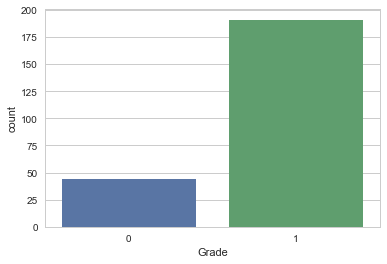

In [8]:
# Visualize counts of classes
gradebox = sns.countplot(x="Grade", data = radiomic_filtered)
gradebox.set_xlabel('Grade')
fig = gradebox.get_figure()

## Model building

Data was randomly split into training and testing sets with a test size = 0.2, yielding training sets containing 196 samples and testing sets containing 49 samples. To prevent class imbalances from affecting classifiers, synthetic minority upsampling (SMOTE) was applied to the training set. Z-score normalization, an often necessary pre-processing step in dimensionality reduction, was used to standardize features with respect to the training set. 
In order to investigate and compare different dimensionality reduction and classification methods, we constructed a three-dimensional parameter grid for analysis. For each of the four dimensionality reduction methods, we incrementally selected the number of dimensions (e.g. principal components) ranging from 1 to 15 in steps of 2 (n = 1, 3, 5, …, 15). These subsets of dimensions were evaluated using each of the nine machine learning classifiers and training data to build a predictive machine learning model. The model was then evaluated on the test set by calculating the area under the receiver operating curve (AUC) score. This was repeated 100 times for each combination with different random splits through a bootstrap approach. The mean of the AUC values ($μ_{AUC}$) over all iterations was calculated to determine the final AUC value for a given model. By calculating the mean over 100 iterations we are able to ensure a more representative value for each model. Similarly, an empirical metric for stability, relative standard deviation (RSD) was previously defined as: 

$$ RSD = \frac{σ_{AUC}}{μ_{AUC}} * 100 $$

where $σ_{AUC}$ and $μ_{AUC}$ are the standard deviation and mean of the 100 AUC values respectively. It should be noted that higher stability corresponds to lower RSD values. 

To investigate machine learning approaches for glioma grade prediction, a total of 3540 radiomic features were extracted from the segmented tumor regions of the pre-treatment multi-modal MRI scans of the BraTS dataset. The output classes were LGG or GBM. Feature reduction and classification training was done using the training set, whereas the testing set was used to assess performance and stability. An outline of the radiomic workflow for the glioma grade classification task is shown in the figure below. 


<img src="workflow_overview.png">

In [9]:
%%time

### Create dataframe where all values will be stored for each combo
master_df = pd.DataFrame(columns = [
    'CLF', 'FSM', 'DN', 
    'AUC_mean', 'AUC_median', 'AUC_std',
    'ACC_mean', 'ACC_median', 'ACC_std',
    'SENS_mean', 'SENS_median', 'SENS_std',
    'P_mean' 
]) 

### Instantiate classifiers
clf_A = DecisionTreeClassifier(random_state=0)  # Ensure all classifiers are set to random states if applicable 
clf_B = RandomForestClassifier(random_state=0)
clf_C = BaggingClassifier(random_state=0)
clf_D = GradientBoostingClassifier(random_state=0)
clf_E = GaussianNB()
clf_F = MLPClassifier(random_state=0)
clf_G = SVC(random_state=0, probability=True) # Need probability to be true so can use AUC score 
clf_H = LogisticRegression(random_state=0)
clf_I = KNeighborsClassifier()
clf_list = [clf_A, clf_B, clf_C, clf_D, clf_E, clf_F, clf_G, clf_H, clf_I]

### Variables for classifier/dimension number combinations
dimension_number_list = range(1,17,2) # number of dimensions to try
score_func_list = ['FILT', 'PCA', 'KPCA','ICA', 'FA'] # dimensionality reduction techniques

### Main script
for clf in clf_list:
    for score_func in score_func_list:
        for dimension_number in dimension_number_list:
            
            auc_list = [] # Empty lists to be filled corresponding to scoring metrics
            accuracy_list = []
            sensitivity_list = []
            p_list = [] 
            
            ### Split dataset randomly, 100 iterations 
            for i in range(100):
                X = radiomic_filtered.drop('Grade',axis = 1)
                y = radiomic_filtered['Grade']
                features_train, features_test, survival_classes_train, survival_classes_test = train_test_split(X,y, train_size = 0.8, random_state=i)
                
                ### Use these variables to calculate p-values later
                survival_classes_test_values = survival_classes_test.values # the number of 1's and 0's 
                size = survival_classes_test_values.size # total size of number of 1's and 0's (should be 47)
                ones = np.count_nonzero(survival_classes_test_values, axis=None) # number of ones (positive class)
                zeros = size-ones # number of zeros
                pctg_1 = float(ones)/float(size) # percentage of 1s
                pctg_0 = float(zeros)/float(size) # percentage of 0s
        
                ### Perform Synthetic Upsampling on training set only  
                sm = SMOTE(random_state=0)
                features_train, survival_classes_train = sm.fit_sample(features_train, survival_classes_train)
                
                ### Use make_pipeline to create feature reduction object that normalizes features
                if score_func == 'FILT':
                    clf_pipe = make_pipeline(StandardScaler(), SelectKBest(k=10), clf) # Univariate filtering feature selection method (ANOVA F-score)
                elif score_func == 'PCA':
                    clf_pipe = make_pipeline(StandardScaler(), PCA(n_components=dimension_number, random_state=0), clf) # Ensure all dimensionality reduction methods are set to random states 
                elif score_func == 'KPCA':
                    clf_pipe = make_pipeline(StandardScaler(), KernelPCA(n_components=dimension_number, kernel='sigmoid', random_state=0), clf)
                elif score_func == 'ICA':
                    clf_pipe = make_pipeline(StandardScaler(), FastICA(n_components=dimension_number, random_state=0), clf)
                elif score_func == 'FA':
                    clf_pipe = make_pipeline(StandardScaler(), FactorAnalysis(n_components=dimension_number, random_state=0), clf)
                    
                clf_pipe.fit(features_train, survival_classes_train) # fit with training data only (important to ONLY use training data to prevent data-leakage)
                
                ### Calculate evluation metrics (AUC, accuracy, p-value, sensitivity)
                auc_list.append(roc_auc_score(survival_classes_test, clf_pipe.predict_proba(features_test)[:,1])) # AUC score, NOTE: Predict proba returns a probability per class ("0", "1") so need [:,1] to get positive class
                acc_score = accuracy_score(survival_classes_test, clf_pipe.predict(features_test)) # need variable for p-value calculation
                accuracy_list.append(acc_score) # Accuracy score
                # P-value calculation as defined in: https://stats.stackexchange.com/questions/154479/definition-of-p-value-in-carets-confusion-matrix-method
                if ones > zeros: # if there are more positive classes in test set 
                    binomial_test_result = binom_test(acc_score*size, size, p=pctg_1, alternative='greater') # binomial test, if you want to compare to random guessing set p=0.5
                else: # if there are more negative classes in test set (unlikely)
                    binomial_test_result = binom_test(acc_score*size, size, p=pctg_0, alternative='greater')
                p_list.append(binomial_test_result) # P-value score
                sensitivity_list.append(recall_score(survival_classes_test, clf_pipe.predict(features_test))) # Sensitivity score
            
            ### Fill dataframe with values
            master_df = master_df.append(
                {
                'CLF': str(clf.__class__.__name__), # classifier name
                'FSM': score_func, # score function name 
                'DN': dimension_number, # number of dimensions 
                'AUC_mean': np.mean(auc_list), 
                'AUC_median': np.median(auc_list),
                'AUC_std': np.std(auc_list),
                'RSD': np.std(auc_list)/np.mean(auc_list)*100, # RSD as defined by Parmer et al 2015 
                'ACC_mean': np.mean(accuracy_list),
                'ACC_median': np.median(accuracy_list),
                'ACC_std': np.std(accuracy_list),
                'SENS_mean': np.mean(sensitivity_list),
                'SENS_median': np.median(sensitivity_list),
                'SENS_std': np.std(sensitivity_list),
                'P_mean': np.mean(p_list)
                }, ignore_index = True)
            #print master_df # uncomment for debugging 
            if score_func == 'FILT':
                break 

/Users/kareemwahid/anaconda/lib/python2.7/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/kareemwahid/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


CPU times: user 10h 6min 7s, sys: 42min 36s, total: 10h 48min 44s
Wall time: 5h 36min 47s


In [10]:
master_df.head()

,CLF,FSM,DN,AUC_mean,AUC_median,AUC_std,ACC_mean,ACC_median,ACC_std,SENS_mean,SENS_median,SENS_std,P_mean,RSD
0,DecisionTreeClassifier,FILT,1,0.794108,0.796766,0.074698,0.843404,0.851064,0.050843,0.879829,0.885714,0.055333,0.360803,9.406526
1,DecisionTreeClassifier,PCA,1,0.666172,0.680535,0.091498,0.689574,0.680851,0.072659,0.704106,0.712406,0.081445,0.875940,13.734950
2,DecisionTreeClassifier,PCA,3,0.702790,0.708503,0.090765,0.767447,0.765957,0.054847,0.808600,0.814145,0.066866,0.692879,12.914954
3,DecisionTreeClassifier,PCA,5,0.750348,0.747091,0.080410,0.817021,0.829787,0.055483,0.863778,0.868421,0.060885,0.480783,10.716312
4,DecisionTreeClassifier,PCA,7,0.750297,0.747505,0.081346,0.816596,0.819149,0.053130,0.860163,0.866643,0.062360,0.494801,10.841785


## Heatmaps

/Users/kareemwahid/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


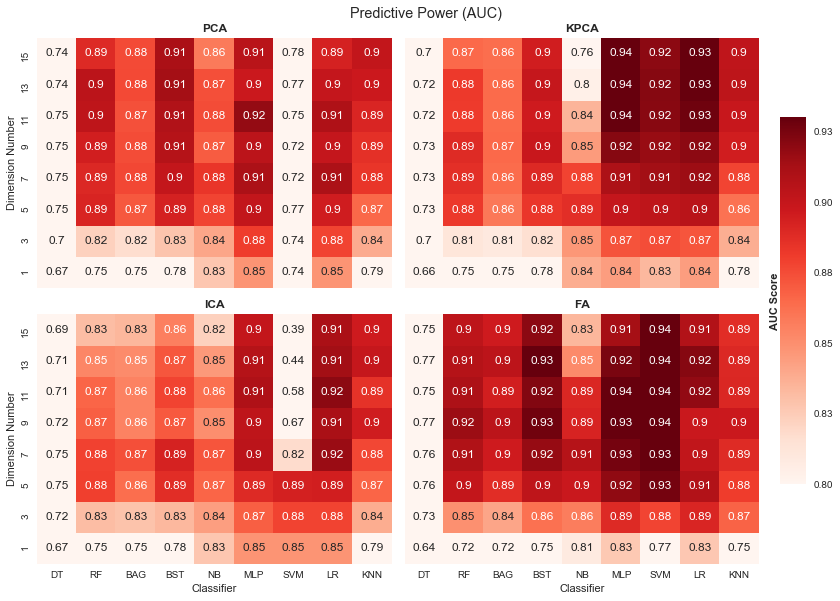

In [11]:
# Predictive performance (AUC) corresponding to classification methods (in columns) 
# and the number of dimensions (in rows) for each dimensionality reduction 
# method for grade classification task.

labels = ['DT', 'RF', 'BAG', 'BST', 'NB', 'MLP', 'SVM', 'LR', 'KNN']

fig, axn = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8.5))
cbar_ax = fig.add_axes([.91, .2, .03, .6])

fsm_list = ['PCA', 'KPCA','ICA', 'FA']
for i, (fsm, ax) in enumerate(zip(fsm_list, axn.flat)):
    dimensionality_reduction_heatmap_df = pd.DataFrame(index = dimension_number_list, columns = [clf.__class__.__name__ for clf in clf_list])
    for dimension_number in dimension_number_list:
        for clf in clf_list:
            dimensionality_reduction_heatmap_df.set_value(dimension_number, clf.__class__.__name__, master_df[(master_df['DN'] == dimension_number) &
                                                                      (master_df['FSM'] == fsm) &
                                                                     (master_df['CLF'] == clf.__class__.__name__)].iloc[0]['AUC_mean']) # actual value
    dimensionality_reduction_heatmap_df = dimensionality_reduction_heatmap_df[dimensionality_reduction_heatmap_df.columns].astype(float)
    heatmap = sns.heatmap(dimensionality_reduction_heatmap_df, ax=ax, cmap = 'Reds', cbar_kws={'label': 'AUC Score', 'format': '%.2f'}, vmin=0.80, vmax=0.93, xticklabels=labels, annot= True, cbar=i == 0, cbar_ax=None if i else cbar_ax)
    heatmap.invert_yaxis()
    if fsm == 'PCA':
        ax.set_title('PCA',fontweight='bold')
        heatmap.set(ylabel='Dimension Number')
        ax.collections[0].colorbar.set_label("AUC Score", fontweight='bold', labelpad=-63)
    elif fsm == 'KPCA':
        ax.set_title('KPCA', fontweight='bold')
    elif fsm == 'ICA':
        ax.set_title('ICA', fontweight='bold')
        heatmap.set(xlabel='Classifier', ylabel='Dimension Number')
    elif fsm == 'FA':
        ax.set_title('FA', fontweight='bold')
        heatmap.set(xlabel='Classifier')
#plt.set_title('Effect of Training Sample Size on AUC')
fig.tight_layout(rect=[0, 0, .9, 1])
fig.suptitle('Predictive Power (AUC)')
fig.subplots_adjust(top=0.93)
#plt.savefig('S2_red.pdf', bbox_inches='tight') # uncomment to save figure

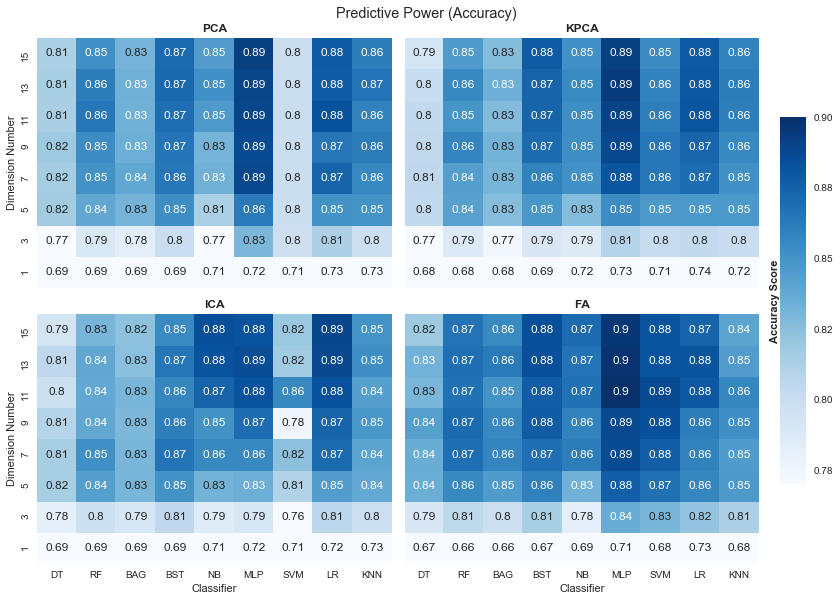

In [12]:
# Predictive performance (Accuracy) corresponding to classification methods (in columns) 
# and the number of dimensions (in rows) for each dimensionality reduction 
# method for grade classification task.

labels = ['DT', 'RF', 'BAG', 'BST', 'NB', 'MLP', 'SVM', 'LR', 'KNN']

fig, axn = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8.5))
cbar_ax = fig.add_axes([.91, .2, .03, .6])

fsm_list = ['PCA', 'KPCA','ICA', 'FA']
for i, (fsm, ax) in enumerate(zip(fsm_list, axn.flat)):
    dimensionality_reduction_heatmap_df = pd.DataFrame(index = dimension_number_list, columns = [clf.__class__.__name__ for clf in clf_list])
    for dimension_number in dimension_number_list:
        for clf in clf_list:
            dimensionality_reduction_heatmap_df.set_value(dimension_number, clf.__class__.__name__, master_df[(master_df['DN'] == dimension_number) &
                                                                      (master_df['FSM'] == fsm) &
                                                                     (master_df['CLF'] == clf.__class__.__name__)].iloc[0]['ACC_mean']) # actual value
    dimensionality_reduction_heatmap_df = dimensionality_reduction_heatmap_df[dimensionality_reduction_heatmap_df.columns].astype(float)
    heatmap = sns.heatmap(dimensionality_reduction_heatmap_df, ax=ax, cmap = 'Blues', cbar_kws={'label': 'Accuracy Score', 'format': '%.2f'}, vmin=0.77, vmax=0.9, xticklabels=labels, annot= True, cbar=i == 0, cbar_ax=None if i else cbar_ax)
    heatmap.invert_yaxis()
    if fsm == 'PCA':
        ax.set_title('PCA',fontweight='bold')
        heatmap.set(ylabel='Dimension Number')
        ax.collections[0].colorbar.set_label("Accuracy Score", fontweight='bold', labelpad=-63)
    elif fsm == 'KPCA':
        ax.set_title('KPCA', fontweight='bold')
    elif fsm == 'ICA':
        ax.set_title('ICA', fontweight='bold')
        heatmap.set(xlabel='Classifier', ylabel='Dimension Number')
    elif fsm == 'FA':
        ax.set_title('FA', fontweight='bold')
        heatmap.set(xlabel='Classifier')   
fig.tight_layout(rect=[0, 0, .9, 1])
fig.suptitle('Predictive Power (Accuracy)')
fig.subplots_adjust(top=0.93)
#plt.savefig('S3_blue.pdf', bbox_inches='tight') # uncomment to save figure

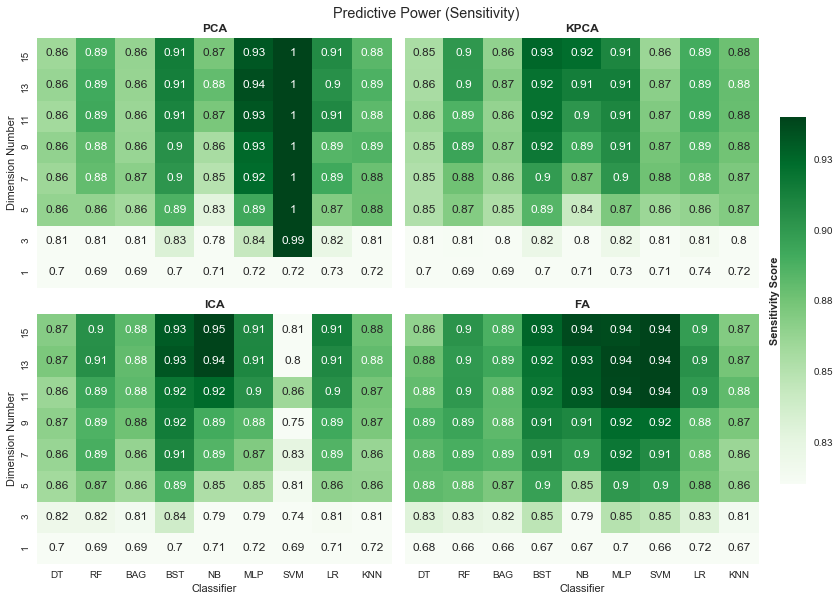

In [13]:
# Predictive performance (Sensitivity) corresponding to classification methods (in columns) 
# and the number of dimensions (in rows) for each dimensionality reduction 
# method for grade classification task.

labels = ['DT', 'RF', 'BAG', 'BST', 'NB', 'MLP', 'SVM', 'LR', 'KNN']

fig, axn = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8.5))
cbar_ax = fig.add_axes([.91, .2, .03, .6])

fsm_list = ['PCA', 'KPCA','ICA', 'FA']
for i, (fsm, ax) in enumerate(zip(fsm_list, axn.flat)):
    dimensionality_reduction_heatmap_df = pd.DataFrame(index = dimension_number_list, columns = [clf.__class__.__name__ for clf in clf_list])
    for dimension_number in dimension_number_list:
        for clf in clf_list:
            dimensionality_reduction_heatmap_df.set_value(dimension_number, clf.__class__.__name__, master_df[(master_df['DN'] == dimension_number) &
                                                                      (master_df['FSM'] == fsm) &
                                                                     (master_df['CLF'] == clf.__class__.__name__)].iloc[0]['SENS_mean']) # actual value
    dimensionality_reduction_heatmap_df = dimensionality_reduction_heatmap_df[dimensionality_reduction_heatmap_df.columns].astype(float)
    heatmap = sns.heatmap(dimensionality_reduction_heatmap_df, ax=ax, cmap = 'Greens', cbar_kws={'label': 'Sensitivity Score', 'format': '%.2f'}, vmin=0.81, vmax=0.94, xticklabels=labels, annot= True, cbar=i == 0, cbar_ax=None if i else cbar_ax)
    heatmap.invert_yaxis()
    if fsm == 'PCA':
        ax.set_title('PCA',fontweight='bold')
        heatmap.set(ylabel='Dimension Number')
        ax.collections[0].colorbar.set_label("Sensitivity Score", fontweight='bold', labelpad=-63)
    elif fsm == 'KPCA':
        ax.set_title('KPCA', fontweight='bold')
    elif fsm == 'ICA':
        ax.set_title('ICA', fontweight='bold')
        heatmap.set(xlabel='Classifier', ylabel='Dimension Number')
    elif fsm == 'FA':
        ax.set_title('FA', fontweight='bold')
        heatmap.set(xlabel='Classifier')   
fig.tight_layout(rect=[0, 0, .9, 1])
fig.suptitle('Predictive Power (Sensitivity)')
fig.subplots_adjust(top=0.93)
#plt.savefig('S4_subset_true.pdf', bbox_inches='tight') # uncomment to save figure

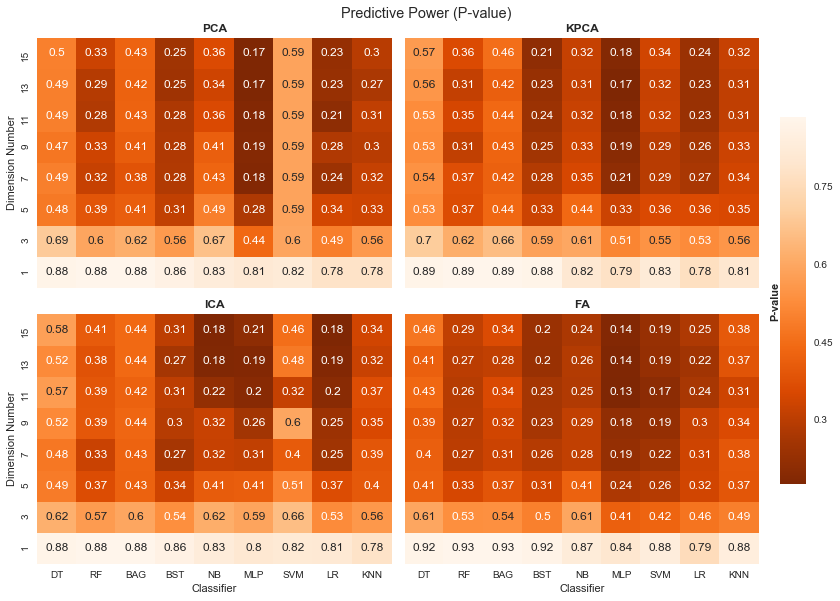

In [14]:
# Predictive performance (P-value) corresponding to classification methods (in columns) 
# and the number of dimensions (in rows) for each dimensionality reduction 
# method for grade classification task.
# Note: These are very high due to the nature of the p-value calculation comparing to the non-information rate, therefore
# since we have an unbalanced dataset, the most reliable metric for evaulation is AUC score.

labels = ['DT', 'RF', 'BAG', 'BST', 'NB', 'MLP', 'SVM', 'LR', 'KNN']

fig, axn = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8.5))
cbar_ax = fig.add_axes([.91, .2, .03, .6])

fsm_list = ['PCA', 'KPCA','ICA', 'FA']
for i, (fsm, ax) in enumerate(zip(fsm_list, axn.flat)):
    dimensionality_reduction_heatmap_df = pd.DataFrame(index = dimension_number_list, columns = [clf.__class__.__name__ for clf in clf_list])
    for dimension_number in dimension_number_list:
        for clf in clf_list:
            dimensionality_reduction_heatmap_df.set_value(dimension_number, clf.__class__.__name__, master_df[(master_df['DN'] == dimension_number) &
                                                                      (master_df['FSM'] == fsm) &
                                                                     (master_df['CLF'] == clf.__class__.__name__)].iloc[0]['P_mean']) # actual value
    dimensionality_reduction_heatmap_df = dimensionality_reduction_heatmap_df[dimensionality_reduction_heatmap_df.columns].astype(float)
    heatmap = sns.heatmap(dimensionality_reduction_heatmap_df, ax=ax, cmap = 'Oranges_r', cbar_kws={'label': 'P-value', 'format': '%.2g'}, xticklabels=labels, fmt='.2g', annot= True, cbar=i == 0, cbar_ax=None if i else cbar_ax)
    heatmap.invert_yaxis()
    if fsm == 'PCA':
        ax.set_title('PCA',fontweight='bold')
        heatmap.set(ylabel='Dimension Number')
        ax.collections[0].colorbar.set_label("P-value", fontweight='bold', labelpad=-63)
    elif fsm == 'KPCA':
        ax.set_title('KPCA', fontweight='bold')
    elif fsm == 'ICA':
        ax.set_title('ICA', fontweight='bold')
        heatmap.set(xlabel='Classifier', ylabel='Dimension Number')
    elif fsm == 'FA':
        ax.set_title('FA', fontweight='bold')
        heatmap.set(xlabel='Classifier')   
fig.tight_layout(rect=[0, 0, .9, 1])
fig.suptitle('Predictive Power (P-value)')
fig.subplots_adjust(top=0.93)
#plt.savefig('P_values.pdf', bbox_inches='tight') # uncomment to save figure

(array([ 0.5,  1.5,  2.5,  3.5,  4.5]), <a list of 5 Text yticklabel objects>)

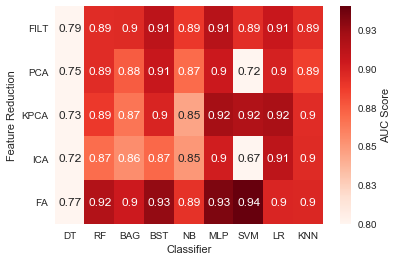

In [15]:
# Heatmap of dimensionality reduction techniques only

master_heatmap_df = pd.DataFrame(index = score_func_list, columns = [clf.__class__.__name__ for clf in clf_list])

for score_func in score_func_list:
    for clf in clf_list: 
        if score_func == 'FILT':
            master_heatmap_df.set_value(score_func, clf.__class__.__name__, master_df[(master_df['DN'] == 1) &
                                                            (master_df['FSM'] == score_func) &
                                                            (master_df['CLF'] == clf.__class__.__name__)].iloc[0]['AUC_mean']) # actual value
            master_heatmap_df = master_heatmap_df[master_heatmap_df.columns].astype(float)
        else:
            master_heatmap_df.set_value(score_func, clf.__class__.__name__, master_df[(master_df['DN'] == 9) &
                                                            (master_df['FSM'] == score_func) &
                                                            (master_df['CLF'] == clf.__class__.__name__)].iloc[0]['AUC_mean']) # actual value
            master_heatmap_df = master_heatmap_df[master_heatmap_df.columns].astype(float)

heatmap = sns.heatmap(master_heatmap_df, cmap = 'Reds', cbar_kws={'label': 'AUC Score', 'format': '%.2f'}, vmin=0.80, vmax=0.94, xticklabels=labels, annot= True)
heatmap.set(xlabel='Classifier', ylabel='Feature Reduction') 
plt.yticks(rotation=0)

Models constructed from Maximum 2D diameter features(DIAM) from each phenotype were constructed to see how our radiomic methods would compare against a routinely accessible prognostic radiological metric. 

In [16]:
%%time
### Diameter features  

volume_df = pd.DataFrame(columns = [
    'CLF', 'FSM', 'DN', 
    'AUC_mean', 'AUC_median', 'AUC_std',
    'ACC_mean', 'ACC_median', 'ACC_std',
    'SENS_mean', 'SENS_median', 'SENS_std'
]) # create dataframe where all values will be stored for each combo)

radiomic_filtered_copy = radiomic_filtered.copy()

radiomic_filtered_copy = radiomic_filtered_copy[['Grade',
                                                 'original_shape_Maximum2DDiameterSlice_necrosis', 
                                                 'original_shape_Maximum2DDiameterSlice_edema', 
                                                 'original_shape_Maximum2DDiameterSlice_enhancing'
                                                ]] # Radiologist approx

for clf in clf_list:
    auc_list = []
    accuracy_list = []
    sensitivity_list = []
    
    for i in range(100):
        X2 = radiomic_filtered_copy.drop('Grade',axis = 1)
        y2 = radiomic_filtered_copy['Grade']
        features_train2, features_test2, survival_classes_train2, survival_classes_test2 = train_test_split(X2,y2, train_size = 0.8, random_state=i) 
        
        # SMOTE
        sm = SMOTE(random_state=0)
        features_train2, survival_classes_train2 = sm.fit_sample(features_train2, survival_classes_train2)
        
        clf_pipe = make_pipeline(StandardScaler(), clf)
        clf_pipe.fit(features_train2, survival_classes_train2)
        
        auc_list.append(roc_auc_score(survival_classes_test2, clf_pipe.predict_proba(features_test2)[:,1])) # AUC score NOTE: Predict proba returns a probability per class ("0", "1") so need [:,1] to get positive class     
        accuracy_list.append(accuracy_score(survival_classes_test2, clf_pipe.predict(features_test2))) # accuracy score 
        sensitivity_list.append(recall_score(survival_classes_test2, clf_pipe.predict(features_test2))) # sensitivity list 
                
    volume_df = volume_df.append({
                'CLF': str(clf.__class__.__name__), # classifier name
                'FSM': 'DIAM', # score function name 
                'DN': 1, # number of dimensions 
                'AUC_mean': np.mean(auc_list), 
                'AUC_median': np.median(auc_list),
                'AUC_std': np.std(auc_list),
                'RSD': np.std(auc_list)/np.mean(auc_list)*100, # RSD as defined by Parmer et al 2015 
                'ACC_mean': np.mean(accuracy_list),
                'ACC_median': np.median(accuracy_list),
                'ACC_std': np.std(accuracy_list),
                'SENS_mean': np.mean(sensitivity_list),
                'SENS_median': np.median(sensitivity_list),
                'SENS_std': np.std(sensitivity_list)             
                }, ignore_index = True)
    #print volume_df #debugging 

CPU times: user 1min 3s, sys: 1.71 s, total: 1min 5s
Wall time: 1min 5s


In [17]:
frames = [master_df, volume_df]
merged_df = pd.concat(frames)

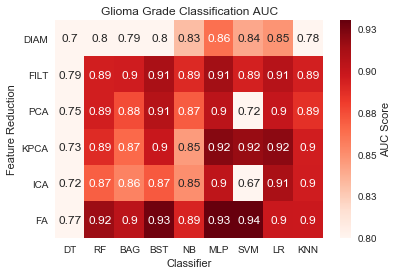

In [18]:
# Heatmap of dimensionality reduction techniques and comparison to diameter

new_score_list2 = ['DIAM', 'FILT', 'PCA', 'KPCA', 'ICA', 'FA']

merged_df_heatmap = pd.DataFrame(index = new_score_list2, columns = [clf.__class__.__name__ for clf in clf_list])

for score_func in new_score_list2:
    for clf in clf_list:
        if score_func == 'FILT' or score_func == 'DIAM':
            merged_df_heatmap.set_value(score_func, clf.__class__.__name__, merged_df[(merged_df['DN'] == 1) &
                                                            (merged_df['FSM'] == score_func) &
                                                            (merged_df['CLF'] == clf.__class__.__name__)].iloc[0]['AUC_mean']) # actual value
            merged_df_heatmap = merged_df_heatmap[merged_df_heatmap.columns].astype(float)
        else:
            merged_df_heatmap.set_value(score_func, clf.__class__.__name__, merged_df[(merged_df['DN'] == 9) &
                                                            (merged_df['FSM'] == score_func) &
                                                            (merged_df['CLF'] == clf.__class__.__name__)].iloc[0]['AUC_mean']) # actual value
            merged_df_heatmap = merged_df_heatmap[merged_df_heatmap.columns].astype(float)

heatmap = sns.heatmap(merged_df_heatmap, cmap = 'Reds', cbar_kws={'label': 'AUC Score', 'format': '%.2f'}, vmin=0.80, vmax=0.93, xticklabels=labels, annot= True)
heatmap.set(xlabel='Classifier', ylabel='Feature Reduction') 
plt.yticks(rotation=0)
plt.title('Glioma Grade Classification AUC')
#plt.savefig('M2_reds.pdf', bbox_inches='tight') # uncomment to save figure

## Scatterplot of stability vs. predictive performance 

In [19]:
# Representative DF

new_score_list3 = ['PCA', 'KPCA', 'ICA', 'FA']

rep_df = pd.DataFrame(index = [clf.__class__.__name__ for clf in clf_list], columns = ['AUC_mean', 'RSD'])

for clf in clf_list:
    for column in rep_df.columns:
        rep_df.set_value(clf.__class__.__name__, column, 
                        master_df[( 
                                   (master_df.FSM != 'FILT') & 
                                   (master_df.CLF == clf.__class__.__name__) & 
                                   (master_df.DN == 9))][column].median())
        
rep_df.index.name = 'CLF'
rep_df = rep_df.reset_index()

rep_df

,CLF,AUC_mean,RSD
0,DecisionTreeClassifier,0.742963,11.675
1,RandomForestClassifier,0.891802,6.64243
2,BaggingClassifier,0.870398,7.52265
3,GradientBoostingClassifier,0.902753,6.05408
4,GaussianNB,0.860104,9.43724
5,MLPClassifier,0.913018,5.81208
6,SVC,0.820702,7.15995
7,LogisticRegression,0.905815,6.27427
8,KNeighborsClassifier,0.89533,6.80894


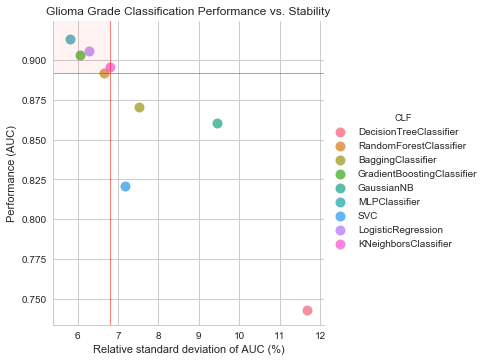

In [20]:
# Representative Scatter 

# Get median values 
AUC_median = rep_df['AUC_mean'].median()
RSD_median = rep_df['RSD'].median()

# Create scatterplot
lm = sns.lmplot(
    x="RSD", y="AUC_mean", hue = 'CLF', data = rep_df, legend = True, legend_out = True,
    fit_reg=False, scatter_kws={"s": 100}
)

# Set labels
lm.set_ylabels('Performance (AUC)')
lm.set_xlabels('Relative standard deviation of AUC (%)')

# Get axis extrema to draw lines and boxes
axes = plt.gca()
y_min, y_max = axes.get_ylim()
x_min, x_max = axes.get_xlim()

# Plot median lines for AUC and RSD + highlighted area for classifiers with AUC > median and RSD < median
plt.axhline(y= AUC_median, linewidth=1, color = 'red', alpha=0.5)
plt.axvline(x= RSD_median, linewidth=1, color = 'red', alpha=0.5)
lm.axes[0][0].add_patch(patches.Rectangle((x_min, AUC_median), width= (RSD_median-x_min), height=(y_max-AUC_median),facecolor="red", alpha = 0.05))
plt.title('Glioma Grade Classification Performance vs. Stability')
#plt.savefig("M3_subset_true.pdf", bbox_inches='tight') # uncomment to save figure


## ANOVA
There are 3 main experimental factors in our study which can affect the radiomics based prediction: classifier method (RF, NB, DT, BAG, BST, SVM, LR, MLP, KNN), dimensionality reduction method (PCA, KPCA, ICA, FA), and number of dimensions selected (1,3,5,…,15). Multifactor analysis of variance (ANOVA) was utilized to quantify the variability in AUC scores contributed by these factors and their interactions. The python statistical library statsmodels was used for the ANOVA analysis. In order to compare the variability contributed by each factor, the variance (sum of squares) calculated for each factor was divided by total variance and multiplied by 100 to yield the percent variance for each factor. 

In [21]:
# Fit linear model 
cw_lm = smf.ols(
    'AUC_mean ~ C(CLF) + C(FSM) + C(DN) + C(CLF)*C(DN) + \
    C(FSM)*C(DN) + C(CLF)*C(FSM)', 
    data=master_df[(master_df.FSM != 'FILT')] # Drop FILT  #Specify C for Categorical
).fit() 


# Create ANOVA from linear model 
anova = anova_lm(cw_lm, typ=1) 
anova.index.name = 'Experimental Factors'
anova.reset_index(inplace=True)
anova['sum_sq'] = anova['sum_sq'].apply(lambda x: (x / anova['sum_sq'].sum())*100) # Tranform sum sq to % variance
anova = anova.rename(columns={'sum_sq': '% Variance'}) # Rename to variance 

anova 

/Users/kareemwahid/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/kareemwahid/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/kareemwahid/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,Experimental Factors,df,% Variance,mean_sq,F,PR(>F)
0,C(CLF),8.0,42.328246,0.091612,65.683028,8.886084e-48
1,C(FSM),3.0,3.873811,0.022358,16.029872,3.278182e-09
2,C(DN),7.0,15.012535,0.037134,26.623728,2.496336e-24
3,C(CLF):C(DN),56.0,7.104012,0.002196,1.574811,1.440344e-02
4,C(FSM):C(DN),21.0,4.054042,0.003343,2.396524,1.120153e-03
5,C(CLF):C(FSM),24.0,14.094281,0.010168,7.290286,4.998797e-16
6,Residual,168.0,13.533072,0.001395,NaN,NaN


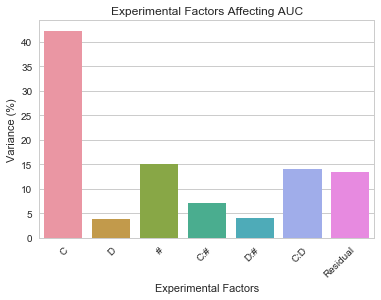

In [22]:
# Creat bar plot for ANOVA factors 
anovaplot = sns.barplot(x="Experimental Factors", y="% Variance", data=anova)

# Change labels 
anovaplot.set_ylabel('Variance (%)')
anovaplot.set_xticklabels(['C', 'D', '#', 'C:#', \
                           'D:#', 'C:D', 'Residual'], ha='right', rotation=45, rotation_mode = 'anchor')

plt.title('Experimental Factors Affecting AUC')
fig = anovaplot.get_figure()
#fig.savefig("M4_diffabbreviations.pdf", bbox_inches='tight') # uncomment to save figure

## Effect of Training Size on Model Performance
Training sample size is often a key factor in radiomics-based predictive analysis. This is particularly true in the realm of clinical medicine, as patient data is often scarce. To investigate the robustness of our radiomics prediction pipeline, we analyzed different training sample sizes using FA with 9 dimensions. We find that most classifiers converge to a maximum predictive performance around 75-100 samples, consistent with previous machine learning studies noting the number of samples necessary for minimizing error. Therefore, while this study may benefit from additional data, it is not necessary to achieve maximum performance in this dataset. 

In [23]:
%%time

linecomp_df = pd.DataFrame(columns = [
    'CLF', 'TS', 'DN', 
    'AUC_mean', 'AUC_median', 'AUC_std',
    'ACC_mean', 'ACC_median', 'ACC_std',
    'SENS_mean', 'SENS_median', 'SENS_std'
]) # create dataframe where all values will be stored for each combo

clf_A = DecisionTreeClassifier(random_state=0)  # Ensure all classifiers are set to random states if applicable 
clf_B = RandomForestClassifier(random_state=0)
clf_C = BaggingClassifier(random_state=0)
clf_D = GradientBoostingClassifier(random_state=0)
clf_E = GaussianNB()
clf_F = MLPClassifier(random_state=0)
clf_G = SVC(random_state=0, probability=True) # Need probability to be true so can use AUC score 
clf_H = LogisticRegression(random_state=0)
clf_I = KNeighborsClassifier()
clf_list = [clf_A, clf_B, clf_C, clf_D, clf_E, clf_F, clf_G, clf_H, clf_I]

score_func_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # build with these training sizes 


for clf in clf_list:
    for score_func in score_func_list:
            
        auc_list = [] # Empty lists to be filled 
        accuracy_list = []
        sensitivity_list = []
            
        # Split dataset randomly 100 times 
        for i in range(100):
            
            X = radiomic_filtered.drop('Grade',axis = 1)
            y = radiomic_filtered['Grade']
            features_train, features_test,survival_classes_train, survival_classes_test = train_test_split(
                X,y, train_size = score_func, random_state=i, stratify=y)  # stratify y so AUC works 
            
            # Not using SMOTE since it has trouble with very small training sizes
            # Perform Synthetic Upsampling on training set only  
            #sm = SMOTE(random_state=0)
            #features_train, survival_classes_train = sm.fit_sample(features_train, survival_classes_train)
                
            clf_pipe = make_pipeline(StandardScaler(), FactorAnalysis(n_components=9, random_state=0), clf)
                    
            clf_pipe.fit(features_train, survival_classes_train) # fit with training data only  
                
            auc_list.append(roc_auc_score(survival_classes_test, clf_pipe.predict_proba(features_test)[:,1])) # AUC score NOTE: Predict proba returns a probability per class ("0", "1") so need [:,1] to get positive class
            accuracy_list.append(accuracy_score(survival_classes_test, clf_pipe.predict(features_test))) # accuracy score
            sensitivity_list.append(recall_score(survival_classes_test, clf_pipe.predict(features_test))) # sensitivity list
                
        linecomp_df = linecomp_df.append(
            {
            'CLF': str(clf.__class__.__name__), # classifier name
            'TS': score_func, # score function name 
            'DN': 9, # number of dimensions 
            'AUC_mean': np.mean(auc_list), 
            'AUC_median': np.median(auc_list),
            'AUC_std': np.std(auc_list),
            'RSD': np.std(auc_list)/np.mean(auc_list)*100, # RSD as defined by Parmer et al 2015 
            'ACC_mean': np.mean(accuracy_list),
            'ACC_median': np.median(accuracy_list),
            'ACC_std': np.std(accuracy_list),
            'SENS_mean': np.mean(sensitivity_list),
            'SENS_median': np.median(sensitivity_list),
            'SENS_std': np.std(sensitivity_list)             
            }, ignore_index = True)
        #print linecomp_df #debugging 


/Users/kareemwahid/anaconda/lib/python2.7/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


CPU times: user 4h 51min 48s, sys: 17min 18s, total: 5h 9min 6s
Wall time: 2h 32min 59s


In [24]:
linecomp_df_copy = linecomp_df.copy()
linecomp_df_copy['TS'] = linecomp_df_copy['TS'].replace([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [12, 24, 47, 71, 94, 118, 141, 165, 188, 212])
linecomp_df_copy['CLF'] = linecomp_df_copy['CLF'].replace(['DecisionTreeClassifier',
                                                           'RandomForestClassifier',
                                                           'BaggingClassifier',
                                                            'GradientBoostingClassifier',
                                                            'GaussianNB',
                                                            'MLPClassifier',
                                                            'SVC',
                                                            'LogisticRegression',
                                                            'KNeighborsClassifier'], 
                                                            labels)
#linecomp_df_copy

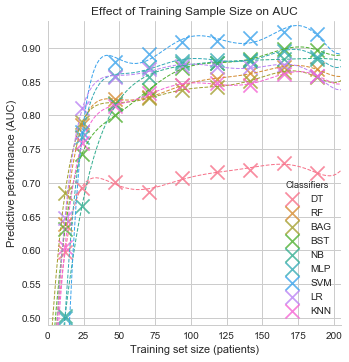

In [25]:
ax = sns.lmplot(x="TS", y="AUC_mean", hue="CLF", data=linecomp_df_copy, 
           fit_reg=True, order=7, ci=None, line_kws={'linestyle': '--', 'linewidth': 1},
                legend_out = False, scatter_kws={'s':200}, markers='x')

ax.set(ylim=(0.49, 0.94))
ax.set(xlim=(0, 205))
ax.set_ylabels('Predictive performance (AUC)')
ax.set_xlabels('Training set size (patients)') 
ax.set(title='Effect of Training Sample Size on AUC')

leg = ax.axes.flat[0].get_legend() # set legend title, https://stackoverflow.com/questions/45201514/edit-seaborn-plot-figure-legend
new_title = 'Classifiers'
leg.set_title(new_title)

#ax.savefig("S5.pdf", bbox_inches='tight') # uncomment to save figure